In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
%matplotlib inline
import scipy.stats as stats
import statsmodels as sm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

# Data Load In 

In [3]:
import Scripts_SigNonSig_V2
reload(Scripts_SigNonSig_V2)
from Scripts_SigNonSig_V2 import * 

In [4]:
import Scripts_Hierarchical_Boot_V2
reload(Scripts_Hierarchical_Boot_V2)
from Scripts_Hierarchical_Boot_V2 import * 

/Users/chris/anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
out = get_data_for_sig_nonsig_analyses(version='v8b')
df_50_nonsig = out['df_50_nonsig']
df_50_sig = out['df_50_sig']

Scripts_SigNonSig_V2.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_simple_one_region = data_simple_one_region[np.logical_not(np.isnan(df.loc[:,'Accuracy.50']))]
Scripts_SigNonSig_V2.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  region_data_single_row['Accuracy.50'] = np.mean(region_data['Accuracy.50'])


# recenter the null 

- then look at threshold 1, not 2

In [7]:
df_50_nonsig['Accuracy.50'] = df_50_nonsig['Accuracy.50']-df_50_nonsig['Accuracy.50'].mean()+0.5

# Boot-Strap Both Distributions

- whole bootstrapping code written here because need both sig and non sig distributions to get the overlap through bootstrapping

In [8]:
num_boots = 500
#accs_boot = np.empty((num_boots,len(df_50_sig)))

#prob_less_than
meann = np.array([])
mediann = np.array([])

meann_non = np.array([])
mediann_non = np.array([])

prob_less_than_62 = np.array([])

sig_thresh1 = np.array([])
sig_thresh2 = np.array([])

prob_less_than_thresh1 = np.array([])
prob_less_than_thresh2 = np.array([])


x = np.linspace(0,1,100) # what range for cdf # 

epcdf_store_non = np.empty((num_boots,len(x)))
epcdf_store_sig = np.empty((num_boots,len(x)))


eppdf_store_non= np.empty((num_boots,len(x)))
eppdf_store_sig= np.empty((num_boots,len(x)))

for boot in range(num_boots):
                           
    # NON SIGS 
    studies_boot = np.random.choice(df_50_nonsig['PID'].unique(),len(df_50_nonsig['PID'].unique()),replace=True)
    study_accs_boot = np.array([])
    maxes = []
    for pid in studies_boot:
        # sample same number of observations within a pid
         study_acc_b_single = np.random.choice(df_50_nonsig.loc[df_50_nonsig['PID']==pid,'Accuracy.50'],size=len(df_50_nonsig.loc[df_50_nonsig['PID']==pid,'Accuracy.50']),replace=True)
         study_accs_boot= np.append(study_accs_boot,study_acc_b_single)
         maxes.append(np.max(study_acc_b_single))
            
    # store empirical distribution function
    ecdf = sm.distributions.empirical_distribution.ECDF(study_accs_boot)
    epcdf_store_non[boot,:]=ecdf(x)
    
    # store pdf
    kd = kde_scipy(study_accs_boot,x,bw_method='scott')
    eppdf_store_non[boot,:]=kd
    
    maxes = np.array(maxes)
    sig_thresh2_b = maxes.mean()
    sig_thresh2 = np.append(sig_thresh2,sig_thresh2_b)
    
    sig_thresh1_b = np.percentile(study_accs_boot,95)
    sig_thresh1 = np.append(sig_thresh1,sig_thresh1_b)
    
    meann_non = np.append(meann_non,np.mean(study_accs_boot))
    mediann_non = np.append(mediann_non,np.median(study_accs_boot))
    
    mn = np.mean(study_accs_boot)
    
    # SIGS 
    studies_boot = np.random.choice(df_50_sig['PID'].unique(),len(df_50_sig['PID'].unique()),replace=True)
    study_accs_boot = np.array([])
    for pid in studies_boot:
        # sample same number of observations within a pid
         study_accs_boot= np.append(study_accs_boot,np.random.choice(df_50_sig.loc[df_50_sig['PID']==pid,'Accuracy.50'],size=len(df_50_sig.loc[df_50_sig['PID']==pid,'Accuracy.50']),replace=True))
    
    ms = np.mean(study_accs_boot)
    
    # effect size (population effect)
    #ms-mn / 
    
    # store empirical distribution function
    ecdf = sm.distributions.empirical_distribution.ECDF(study_accs_boot)
    epcdf_store_sig[boot,:]=ecdf(x)
    
    # store pdf
    kd = kde_scipy(study_accs_boot,x,bw_method='scott')
    eppdf_store_sig[boot,:]=kd
    
    meann = np.append(meann,np.mean(study_accs_boot))
    mediann = np.append(mediann,np.median(study_accs_boot))
    
    prob_less_than_62 = np.append(prob_less_than_62,np.sum(study_accs_boot<.62)/float(len(study_accs_boot)))
    prob_less_than_thresh1 = np.append(prob_less_than_thresh1,np.sum(study_accs_boot<sig_thresh1_b)/float(len(study_accs_boot)))
    prob_less_than_thresh2 = np.append(prob_less_than_thresh2,np.sum(study_accs_boot<sig_thresh2_b)/float(len(study_accs_boot)))
    

# Save 

In [9]:
# not recentered = bootstrap_results

np.savez('../data_meta_analysis/data_derived_meta_analysis/bootstrap_results_together_recenter_v8b',epcdf_store_non=epcdf_store_non,
          epcdf_store_si=epcdf_store_sig,
           eppdf_store_non= eppdf_store_non,
           eppdf_store_sig= eppdf_store_sig,
          meann= meann,
         mediann = mediann,
        meann_non= meann_non,
         mediann_non = mediann_non,
         prob_less_than_62 =prob_less_than_62,
         sig_thresh1=sig_thresh1,
         sig_thresh2=sig_thresh2)

# Load Back In 

In [10]:
#boot_results = np.load('bootstrap_results.npz')
boot_results = np.load('../data_meta_analysis/data_derived_meta_analysis/bootstrap_results_together_recenter_v8b.npz')

In [11]:
x = np.linspace(0,1,100) # what range for cdf # 
epcdf_store_sig = boot_results['epcdf_store_si']
epcdf_store_non = boot_results['epcdf_store_non']
eppdf_store_sig = boot_results['eppdf_store_sig']
eppdf_store_non = boot_results['eppdf_store_non']
meann = boot_results['meann']
mediann = boot_results['mediann']
meann_non = boot_results['meann_non']
mediann_non = boot_results['mediann_non']
prob_less_than_62 = boot_results['prob_less_than_62']
sig_thresh1 = boot_results['sig_thresh1']
sig_thresh2 = boot_results['sig_thresh2']


# CDF and PDF Plots 

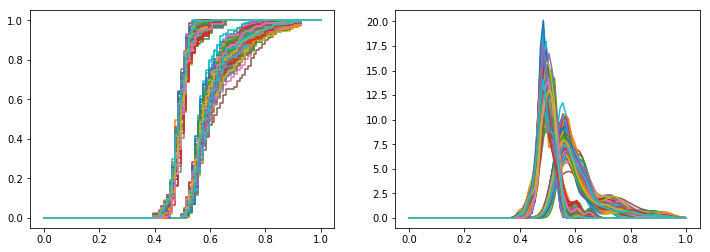

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12,4))

ax1.step(x, epcdf_store_sig.T);
ax1.step(x, epcdf_store_non.T);

ax2.plot(x, eppdf_store_sig.T);
ax2.plot(x, eppdf_store_non.T);

In [13]:
print('prob less than 62')
print(np.percentile(prob_less_than_62,95))
print(np.mean(prob_less_than_62))
print(np.percentile(prob_less_than_62,5))

print('mean')
print(np.percentile(meann,95))
print(np.mean(meann))
print(np.percentile(meann,5))

print('median')
print(np.percentile(mediann,95))
print(np.mean(mediann))
print(np.percentile(mediann,5))

print('mean_non')
print(np.percentile(meann_non,95))
print(np.mean(meann_non))
print(np.percentile(meann_non,5))

print('median_non')
print(np.percentile(mediann_non,95))
print(np.mean(mediann_non))
print(np.percentile(mediann_non,5))

print('thresh 1')
print(np.percentile(sig_thresh1,95))
print(np.mean(sig_thresh1))
print(np.percentile(sig_thresh1,5))

# print('thresh 2')
# print(np.percentile(sig_thresh2,95))
# print(np.mean(sig_thresh2))
# print(np.percentile(sig_thresh2,5))

print('prob less thresh 1')
print(np.percentile(prob_less_than_thresh1,95))
print(np.mean(prob_less_than_thresh1))
print(np.percentile(prob_less_than_thresh1,5))

# print('prob less thresh 2')
# print(np.percentile(prob_less_than_thresh2,95))
# print(np.mean(prob_less_than_thresh2))
# print(np.percentile(prob_less_than_thresh2,5))

prob less than 62
0.738822683139
0.658871230886
0.582918991026
mean
0.627469623302
0.610162682623
0.593997942574
median
0.6
0.5844478
0.57
mean_non
0.508376281429
0.500418486445
0.49400118103
median_non
0.501287955182
0.496867955182
0.491287955182
thresh 1
0.601287955182
0.553415535182
0.531287955182
prob less thresh 1
0.610639163878
0.247551888779
0.0796408666076


# Run again without recentering


In [14]:
out = get_data_for_sig_nonsig_analyses(version='v8b')
df_50_nonsig = out['df_50_nonsig']
df_50_sig = out['df_50_sig']
df_50_nonsig = out['df_50_nonsig']

In [15]:
num_boots = 500
#accs_boot = np.empty((num_boots,len(df_50_sig)))

#prob_less_than
meann = np.array([])
mediann = np.array([])

meann_non = np.array([])
mediann_non = np.array([])

prob_less_than_62 = np.array([])

sig_thresh1 = np.array([])
sig_thresh2 = np.array([])

prob_less_than_thresh1 = np.array([])
prob_less_than_thresh2 = np.array([])


x = np.linspace(0,1,100) # what range for cdf # 

epcdf_store_non = np.empty((num_boots,len(x)))
epcdf_store_sig = np.empty((num_boots,len(x)))


eppdf_store_non= np.empty((num_boots,len(x)))
eppdf_store_sig= np.empty((num_boots,len(x)))

for boot in range(num_boots):
                           
    # NON SIGS 
    studies_boot = np.random.choice(df_50_nonsig['PID'].unique(),len(df_50_nonsig['PID'].unique()),replace=True)
    study_accs_boot = np.array([])
    maxes = []
    for pid in studies_boot:
        # sample same number of observations within a pid
         study_acc_b_single = np.random.choice(df_50_nonsig.loc[df_50_nonsig['PID']==pid,'Accuracy.50'],size=len(df_50_nonsig.loc[df_50_nonsig['PID']==pid,'Accuracy.50']),replace=True)
         study_accs_boot= np.append(study_accs_boot,study_acc_b_single)
         maxes.append(np.max(study_acc_b_single))
            
    # store empirical distribution function
    ecdf = sm.distributions.empirical_distribution.ECDF(study_accs_boot)
    epcdf_store_non[boot,:]=ecdf(x)
    
    # store pdf
    kd = kde_scipy(study_accs_boot,x,bw_method='scott')
    eppdf_store_non[boot,:]=kd
    
    maxes = np.array(maxes)
    sig_thresh2_b = maxes.mean()
    sig_thresh2 = np.append(sig_thresh2,sig_thresh2_b)
    
    sig_thresh1_b = np.percentile(study_accs_boot,95)
    sig_thresh1 = np.append(sig_thresh1,sig_thresh1_b)
    
    meann_non = np.append(meann_non,np.mean(study_accs_boot))
    mediann_non = np.append(mediann_non,np.median(study_accs_boot))
    
    mn = np.mean(study_accs_boot)
    
    # SIGS 
    studies_boot = np.random.choice(df_50_sig['PID'].unique(),len(df_50_sig['PID'].unique()),replace=True)
    study_accs_boot = np.array([])
    for pid in studies_boot:
        # sample same number of observations within a pid
         study_accs_boot= np.append(study_accs_boot,np.random.choice(df_50_sig.loc[df_50_sig['PID']==pid,'Accuracy.50'],size=len(df_50_sig.loc[df_50_sig['PID']==pid,'Accuracy.50']),replace=True))
    
    ms = np.mean(study_accs_boot)
    
    # effect size (population effect)
    #ms-mn / 
    
    # store empirical distribution function
    ecdf = sm.distributions.empirical_distribution.ECDF(study_accs_boot)
    epcdf_store_sig[boot,:]=ecdf(x)
    
    # store pdf
    kd = kde_scipy(study_accs_boot,x,bw_method='scott')
    eppdf_store_sig[boot,:]=kd
    
    meann = np.append(meann,np.mean(study_accs_boot))
    mediann = np.append(mediann,np.median(study_accs_boot))
    
    prob_less_than_62 = np.append(prob_less_than_62,np.sum(study_accs_boot<.62)/float(len(study_accs_boot)))
    prob_less_than_thresh1 = np.append(prob_less_than_thresh1,np.sum(study_accs_boot<sig_thresh1_b)/float(len(study_accs_boot)))
    prob_less_than_thresh2 = np.append(prob_less_than_thresh2,np.sum(study_accs_boot<sig_thresh2_b)/float(len(study_accs_boot)))
    

In [16]:
np.savez('../data_meta_analysis/data_derived_meta_analysis/bootstrap_results_together_v8b',epcdf_store_non=epcdf_store_non,
          epcdf_store_si=epcdf_store_sig,
           eppdf_store_non= eppdf_store_non,
           eppdf_store_sig= eppdf_store_sig,
          meann= meann,
         mediann = mediann,
        meann_non= meann_non,
         mediann_non = mediann_non,
         prob_less_than_62 =prob_less_than_62,
         sig_thresh1=sig_thresh1,
         sig_thresh2=sig_thresh2)

In [17]:
boot_results = np.load('../data_meta_analysis/data_derived_meta_analysis/bootstrap_results_together_v8b.npz')

In [18]:
print('prob less than 62')
print(np.percentile(prob_less_than_62,95))
print(np.mean(prob_less_than_62))
print(np.percentile(prob_less_than_62,5))

print('mean')
print(np.percentile(meann,95))
print(np.mean(meann))
print(np.percentile(meann,5))

print('median')
print(np.percentile(mediann,95))
print(np.mean(mediann))
print(np.percentile(mediann,5))

print('mean_non')
print(np.percentile(meann_non,95))
print(np.mean(meann_non))
print(np.percentile(meann_non,5))

print('median_non')
print(np.percentile(mediann_non,95))
print(np.mean(mediann_non))
print(np.percentile(mediann_non,5))

print('thresh 1')
print(np.percentile(sig_thresh1,95))
print(np.mean(sig_thresh1))
print(np.percentile(sig_thresh1,5))

# print('thresh 2')
# print(np.percentile(sig_thresh2,95))
# print(np.mean(sig_thresh2))
# print(np.percentile(sig_thresh2,5))

print('prob less thresh 1')
print(np.percentile(prob_less_than_thresh1,95))
print(np.mean(prob_less_than_thresh1))
print(np.percentile(prob_less_than_thresh1,5))

# print('prob less thresh 2')
# print(np.percentile(prob_less_than_thresh2,95))
# print(np.mean(prob_less_than_thresh2))
# print(np.percentile(prob_less_than_thresh2,5))

prob less than 62
0.744412698296
0.656521354331
0.579038883689
mean
0.627170752813
0.61052427705
0.593513873527
median
0.6
0.5846545
0.57
mean_non
0.526839329909
0.519164252278
0.512533876369
median_non
0.52
0.515382
0.51
thresh 1
0.62
0.57261626
0.55
prob less thresh 1
0.659519466912
0.369346222795
0.170130067801
